In [86]:
import relaqs.api.gates as gates
import numpy as np
import pandas as pd
import os
from datetime import datetime
from qutip.superoperator import liouvillian, spre, spost
from qutip import Qobj, tensor, Bloch
from qutip.operators import *
import matplotlib.pyplot as plt
from relaqs.api.utils import *
from scipy.linalg import expm

In [87]:
I = gates.I().get_matrix()
X = gates.X().get_matrix()
Y = gates.Y().get_matrix()
Z = gates.Z().get_matrix()

In [88]:
steps_per_Haar = 2
final_time = 35.5556E-9 #in seconds
gamma_phase_max = 1.1675 * np.pi
gamma_magnitude_max = 1.8 * np.pi / final_time / steps_per_Haar
alpha_max = 0.05E9  # detuning of the control pulse in Hz

# Set the number of samples when scanning over a range
num_samples = 100  # Number of values to test per action
actions = np.linspace(-1, 1, num_samples)  # Generate action values from -1 to 1

In [89]:
def compute_bloch_vectors(action_type=None, specified_action=None, default_values= [-1,-1,-1]):
    """
    Computes Bloch vectors for:
    1. A **sweep over a range** of one action while using user-defined defaults for the other two.
    2. A **single specified action set** `[γ_magnitude, γ_phase, α]`.

    Parameters:
    - varying_action: Values of the action being scanned (-1 to 1).
    - action_type: Which action is being varied ("gamma_magnitude", "gamma_phase", or "alpha").
    - specified_action: A list `[γ_magnitude, γ_phase, α]` for a **single specific test**.
    - default_values: Default values `[γ_magnitude, γ_phase, α]` used when varying one action.

    Returns:
    - Array of Bloch vectors.
    """

    if default_values is None:
        default_values = [0, 0, 0]
    bloch_vectors = []  # List to store computed Bloch vectors

    if specified_action is not None:
        # Case 1: Compute for a SPECIFIC action set
        action_sets = [specified_action]
    else:
        # Case 2: Compute for a RANGE of values (keeping other actions at user-defined defaults)
        action_sets = [[action, default_values[1], default_values[2]] if action_type == "gamma_magnitude" else
                       [default_values[0], action, default_values[2]] if action_type == "gamma_phase" else
                       [default_values[0], default_values[1], action]
                       for action in actions]

    # Loop through all action sets
    for action_set in action_sets:
        gamma_magnitude_action, gamma_phase_action, alpha_action = action_set

        # Compute actual control parameters
        gamma_magnitude = gamma_magnitude_max * gamma_magnitude_action
        gamma_phase = gamma_phase_max * gamma_phase_action
        alpha = alpha_max * alpha_action

        # Construct the Hamiltonian
        H = alpha * Z + gamma_magnitude * (np.cos(gamma_phase) * X + np.sin(gamma_phase) * Y)

        # Compute Unitary Evolution: U = exp(-i H t)
        U = expm(-1j * H * final_time)

        # Apply U to initial state |0⟩
        psi_0 = np.array([[1], [0]], dtype=complex)  # |0⟩ state
        psi_final = U @ psi_0  # Evolve under U

        # Compute the Density Matrix: ρ = |ψ⟩⟨ψ|
        rho = psi_final @ psi_final.conj().T

        # Compute Bloch vector components: (x, y, z)
        x = np.real(np.trace(rho @ X))
        y = np.real(np.trace(rho @ Y))
        z = np.real(np.trace(rho @ Z))

        bloch_vectors.append([x, y, z])  # Store the Bloch vector

    return np.array(bloch_vectors)  # Convert list to NumPy array

In [96]:
def plot_bloch_sphere(action_type=None, specified_action=None, default_values=[0, 0, 0]):
    """
    Plots a Bloch sphere for:
    - A **range scan** if `action_type` is provided (with custom defaults for other actions).
    - A **specific action** if `specified_action` is passed as `[γ_magnitude, γ_phase, α]`.

    Parameters:
    - action_type: The action being varied ("gamma_magnitude", "gamma_phase", or "alpha").
    - specified_action: A single action set `[γ_magnitude, γ_phase, α]`.
    - default_values: Default values `[γ_magnitude, γ_phase, α]` used when varying one action.
    """

    # Compute Bloch vectors
    bloch_vectors = compute_bloch_vectors(action_type, specified_action, default_values)

    # Create Bloch sphere object
    bloch_sphere = Bloch()
    bloch_sphere.vector_color = ['m']  # Magenta for clarity

    # Add Bloch vectors
    bloch_sphere.add_points(bloch_vectors.T)  # Transpose needed for correct format
    # Show Bloch sphere
    bloch_sphere.show()


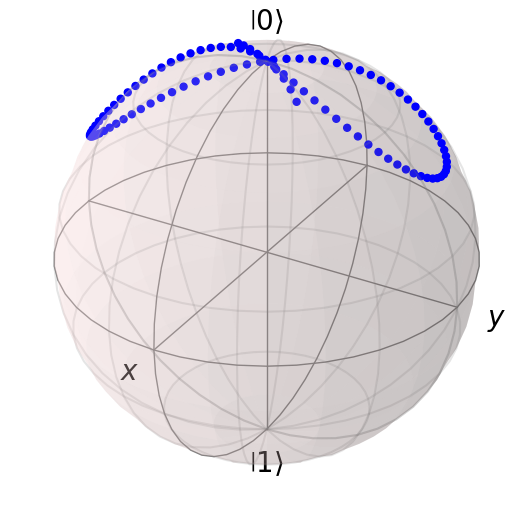

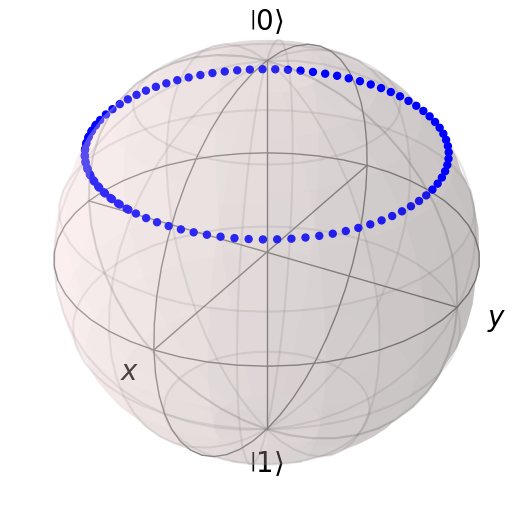

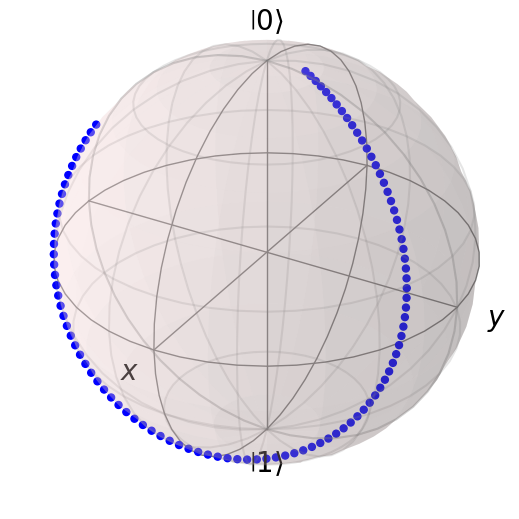

In [102]:
def_values = [0.5, -1, -1]
plot_bloch_sphere("gamma_magnitude", default_values=def_values)
plot_bloch_sphere("gamma_phase", default_values=def_values)
plot_bloch_sphere("alpha", default_values=def_values)
# plot_bloch_sphere(specified_action=[-1,-1,-1])  # User-specified action